### Загружаем и подготавливаем данные:

In [310]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

file_path = 'C:/Users/Ilya/Downloads/archive (4)/exams.csv'
data = pd.read_csv(file_path)
data.columns = data.columns.str.replace(" ", "_")
cleanup = {"gender":     {"male": 1, "female": 0},
                "race/ethnicity": {"group A": 1, "group B": 2, "group C": 3, "group D": 4, "group E": 5},
                "parental_level_of_education": {"bachelor's degree": 1, "high school": 2, "some college": 3,"master's degree": 4,"some high school": 5, "associate's degree": 6},
                "lunch": {"standard": 1, "free/reduced": 0},
                "test_preparation_course": {"completed": 1, "none":0}}
data = data.replace(cleanup)
data.head()

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,1,1,2,1,1,67,67,63
1,0,4,5,0,0,40,59,55
2,1,5,3,0,0,59,60,50
3,1,2,2,1,0,77,78,68
4,1,5,6,1,1,78,73,68


Посмотрим на гистограммы распределения оценок, как видно близки к нормальному распределению:

<Figure size 640x480 with 0 Axes>

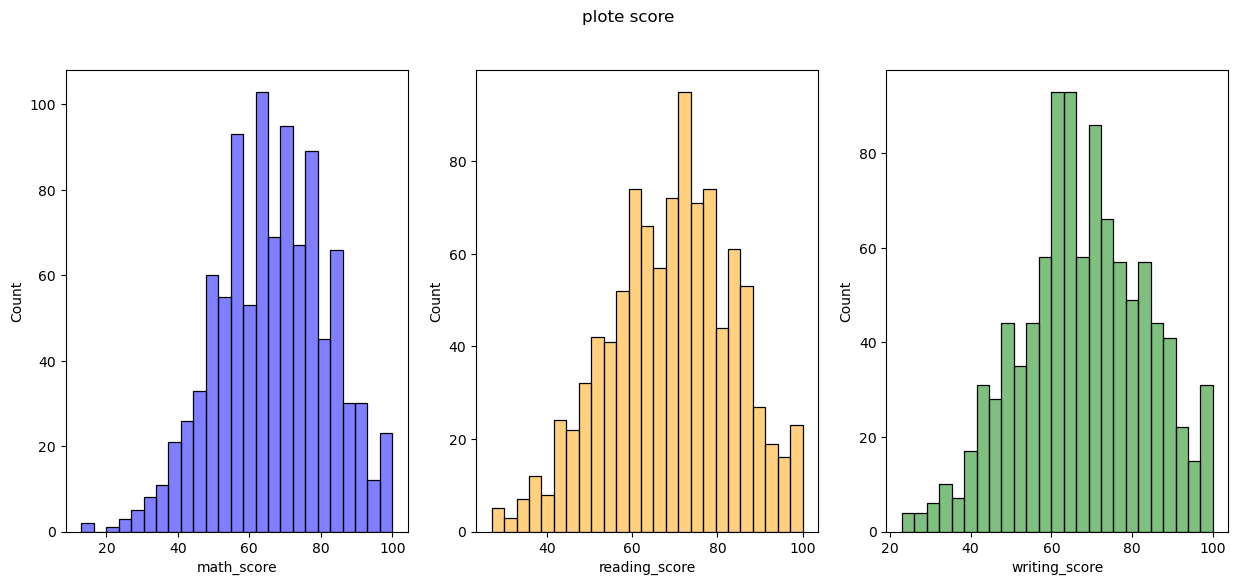

In [344]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(4)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('plote score')
sns.histplot(data['math_score'], color='blue', ax=ax[0], alpha=0.5, bins=25) 
sns.histplot(data['reading_score'], color='orange', ax=ax[1], alpha=0.5, bins=25) 
sns.histplot(data['writing_score'], color='green', ax=ax[2], alpha=0.5, bins=25) 
plt.show()

Посмотрим как различаются оценки, у мальчиков и девочек. Как можно заметить, при прочих равных мальчикам дается 
легче математика, а девочкам написание. Написание и чтение и мальчики и девочки пишут примерно одинаково. Так же понятно,
что оценка в написании или чтении коррелирует с успехом в математике. Это вполне интуитивно понятный результат, который можно объяснить так: "человек который, хорошо читает или пишет, в среднем имеет выше балл по математике, чем человек, который плох в чтении или правописании"

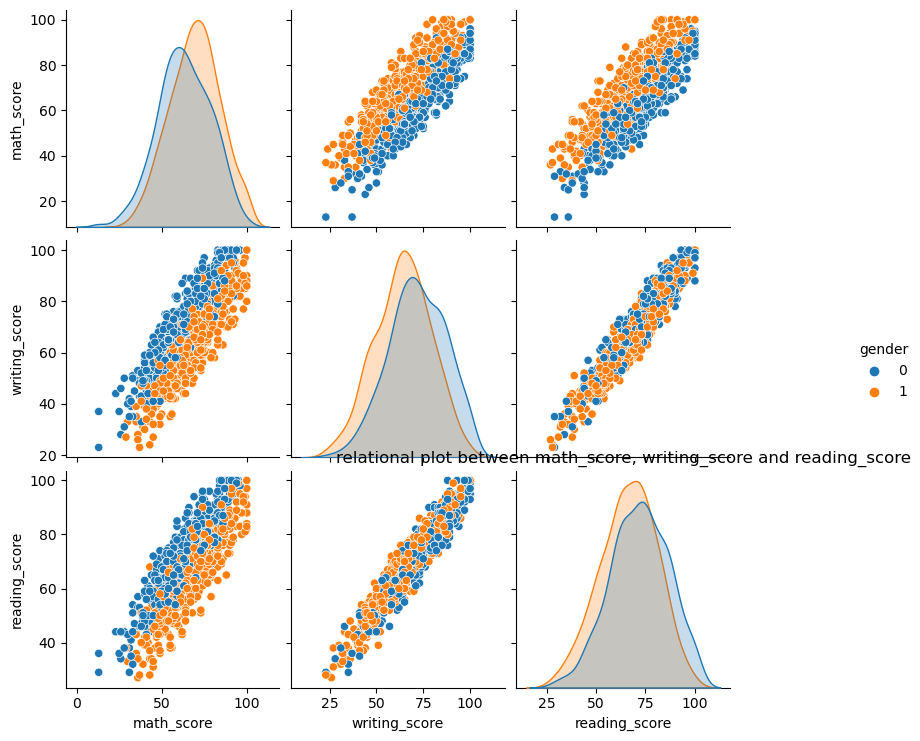

In [327]:
data1 = data[['math_score', 'writing_score', 'reading_score', 'gender']]
sns.pairplot(data = data1, hue="gender")
plt.title("relational plot between math_score, writing_score and reading_score")
plt.savefig("pairplot_score_features.png")

Пример еще нескольких графиков, показывающих линейную зависимость между результатами на экзаменах. 

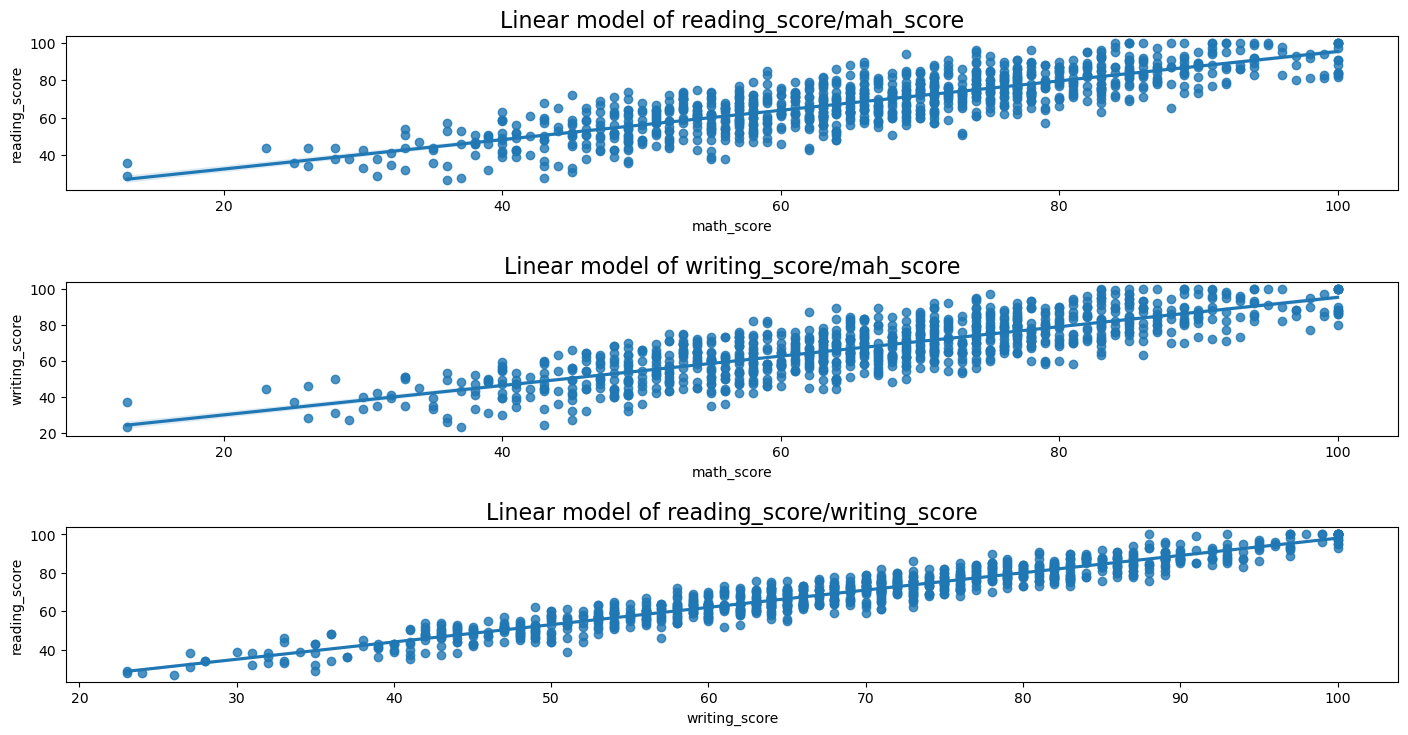

In [329]:
variables = ["math_score", "reading_score", "writing_score"]
fig, ax = plt.subplots(3, 1, figsize = (15, 8))
ax = ax.flat
fig.tight_layout(pad = 4.5)
sns.regplot(x = variables[0], y = variables[1], data = data, ax = ax[0])
ax[0].set_title("Linear model of reading_score/mah_score", fontsize = 16)
sns.regplot(x = variables[0], y = variables[2], data = data, ax = ax[1])
ax[1].set_title("Linear model of writing_score/mah_score", fontsize = 16)
sns.regplot(x = variables[2], y = variables[1], data = data, ax = ax[2])
ax[2].set_title("Linear model of reading_score/writing_score", fontsize = 16)
plt.savefig("linear_models.png")

### обучаем модель машинного обучения
Теперь обучим модель машинного обучения, которая будет предсказывать результат на экзамене по математике:

In [340]:
y = data.math_score
feature_names = ['gender', 'race/ethnicity','parental_level_of_education', 'lunch', 'test_preparation_course', 'reading_score']
#, 'writing_score', 'reading_score'
X = data[feature_names]

In [341]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)


In [342]:
model = RandomForestRegressor(n_estimators = 100, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)
print(mae)

5.549690158730159


Учитывая средний балл за экзамен по математике, мы получили неплохую точность. Теперь посмотрим насколько каждый признак 
сильно влияет на предсказание. Можно заметить, что модель в основном полагается на балл за чтение(балл за правописание
не входит в модель). Т.к баллы очень сильно коррелируют между собой, это вполне ожидаемый результат. Построим новую модель, 
у которой в распоряжении не будет баллов за другие экзамены.

In [343]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(val_X,val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
1.5184 ± 0.2146,reading_score
0.2874 ± 0.0323,gender
0.0526 ± 0.0239,lunch
0.0153 ± 0.0182,race/ethnicity
0.0038 ± 0.0036,test_preparation_course
-0.0045 ± 0.0044,parental_level_of_education


Как можно отметить, ошибка предсказания возросла в два раза, но точность все равно остается хорошей, учитывая малость
ошибок у предыдущей модели. Гораздо интересней, то что теперь основная метрика на которую полагается модель, это
то как хорошо покормили ребенка в день экзамена. При этом курс по подготовке к экзамену, вообще никак
не влияет на оценки по математике, как дальше можно будет увидеть, на этом курсе детей готовили только
к правописанию

In [331]:
y = data.math_score
feature_names = ['gender', 'race/ethnicity','parental_level_of_education', 'lunch', 'test_preparation_course']
#, 'writing_score', 'reading_score'
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
model = RandomForestRegressor(n_estimators = 100, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)
print(mae)
perm = PermutationImportance(model, random_state=1).fit(val_X,val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

11.64009678085511


Weight,Feature
0.2490 ± 0.2150,lunch
0.2042 ± 0.0987,race/ethnicity
0.1137 ± 0.0499,parental_level_of_education
0.0788 ± 0.0560,gender
-0.0035 ± 0.0452,test_preparation_course


Теперь модель будет предсказывать оценки по правописанию. В этой модели все факторы оказались важны. На первом
месте стоит пол. По всей видимости девочки ощутимо лучше проходят экзамен по правописанию. Также стоит заметить,
что подготовка к экзамену вносит ощутимый вклад

In [334]:
y = data.writing_score
feature_names = ['gender', 'race/ethnicity','parental_level_of_education', 'lunch', 'test_preparation_course']
#, 'writing_score', 'reading_score'
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
model = RandomForestRegressor(n_estimators = 100, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)
print(mae)
perm = PermutationImportance(model, random_state=1).fit(val_X,val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

11.273446125148952


Weight,Feature
0.1827 ± 0.0376,gender
0.1510 ± 0.0797,parental_level_of_education
0.1482 ± 0.0754,race/ethnicity
0.1450 ± 0.1287,lunch
0.1342 ± 0.0828,test_preparation_course


Аналогичная модель, только теперь предсказываем балл за чтение. Также важно девочка это или мальчик, кормили хорошо или
нет, проходил ребенок курс подготоввки или нет.

In [335]:
y = data.reading_score
feature_names = ['gender', 'race/ethnicity','parental_level_of_education', 'lunch', 'test_preparation_course']
#, 'writing_score', 'reading_score'
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
model = RandomForestRegressor(n_estimators = 100, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)
print(mae)
perm = PermutationImportance(model, random_state=1).fit(val_X,val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

11.320320757099045


Weight,Feature
0.1425 ± 0.0474,gender
0.1322 ± 0.1306,lunch
0.1263 ± 0.0650,race/ethnicity
0.0998 ± 0.0723,parental_level_of_education
0.0630 ± 0.0657,test_preparation_course


### Вывод

Мальчики в среднем лучше пишут тест по математике, но девочки ощутимо лучше проходят экзамен по правописанию и чтению
(насколько я помню, в моей школе девочки действительно аккуратней и грамотней писали). Неожиданным результатом окащалось,
то что важную роль играет как хорошо поел ребенок перед экзаменом. При этом курс по подготовке к экзаменам оказался полезен 
только в случае правописания и чтения, но никак не отразился на результатах по математике(возможно этот курс и не готовил
к математике)